# Try a simple model for sound classification on our toy dataset

The network architecture is taken from https://towardsdatascience.com/cnns-for-audio-classification-6244954665ab and https://ieeexplore.ieee.org/document/9072379

In [7]:
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
import tensorflow as tf
from glob import glob
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

### Extract Acoustic Features

Let's extract acoustic features: log mel spectrogram

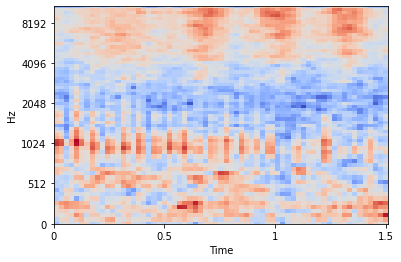

In [8]:
path = "sound/cutting/abnormal/00001.wav"
scale, sr = librosa.load(path)
mel_spectrogram = librosa.feature.melspectrogram(scale, 
                                                 sr, 
                                                 hop_length=512,
                                                 n_mels=64,
                                                 fmax=sr/2)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
librosa.display.specshow(log_mel_spectrogram, x_axis="time", y_axis="mel", sr=sr)

Let's extract acoustic features: MFCCs

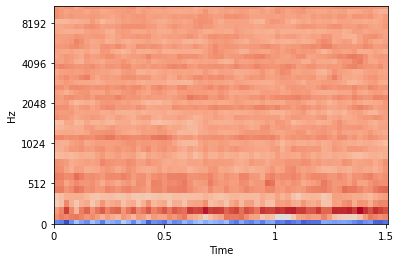

In [9]:
MFCCs=librosa.feature.mfcc(scale, sr, n_mfcc=40, fmax=sr/2)
librosa.display.specshow(MFCCs, x_axis="time", y_axis="mel", sr=sr)

In [10]:
acoustic_features=np.concatenate( (MFCCs,log_mel_spectrogram), axis =0)

In [11]:
acoustic_features.shape

(104, 65)

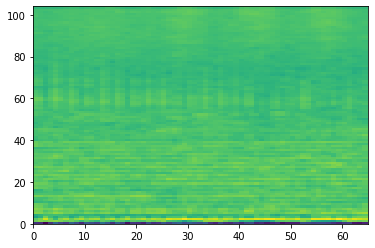

In [12]:
plt.pcolor(acoustic_features)
plt.show()

In [13]:
def acoustic_feature_computation( clip ):
    scale, sr = librosa.load(clip)
    mel_spectrogram = librosa.feature.melspectrogram(scale, 
                                                 sr, 
                                                 hop_length=512,
                                                 n_mels=64,
                                                 fmax=sr/2)
    log_mel = librosa.power_to_db(mel_spectrogram)
    MFCCs=librosa.feature.mfcc(scale, sr, n_mfcc=40, fmax=sr/2)
    acoustic_features=np.concatenate( (MFCCs,log_mel_spectrogram), axis =0)
    return acoustic_features


### Let's complete the feature extraction for all the audio clips

In [14]:
def acoustic_feature_computation( clip ):
    scale, sr = librosa.load(clip)
    mel_spectrogram = librosa.feature.melspectrogram(scale, 
                                                 sr, 
                                                 hop_length=512,
                                                 n_mels=64,
                                                 fmax=sr/2)
    log_mel = librosa.power_to_db(mel_spectrogram)
    MFCCs=librosa.feature.mfcc(scale, sr, n_mfcc=40, fmax=sr/2)
    acoustic_features=np.concatenate( (MFCCs,log_mel_spectrogram), axis =0)
    return acoustic_features


In [15]:
clips=glob('sound/cutting/*/*')
clips_df=pd.DataFrame(data={'path':clips,
                            'label':[0 if c.split('/')[2]=='normal' else 1 for c in clips]} )
clips_df

,path,label
0,sound/cutting/abnormal/00027.wav,1
1,sound/cutting/abnormal/00033.wav,1
2,sound/cutting/abnormal/00032.wav,1
3,sound/cutting/abnormal/00026.wav,1
4,sound/cutting/abnormal/00030.wav,1
...,...,...
193,sound/cutting/normal/00029.wav,0
194,sound/cutting/normal/00003.wav,0
195,sound/cutting/normal/00017.wav,0
196,sound/cutting/normal/00016.wav,0


In [16]:
train, test = train_test_split(clips_df, test_size=0.20, random_state=25)
train, validation = train_test_split(train, test_size=0.20, random_state=25)

In [17]:
X_train=[] 
X_test=[]
X_validation=[]
y_train=[] 
y_test=[]
y_validation=[]

for i,r in train.iterrows():
    X_train.append(acoustic_feature_computation(r['path']))
    y_train.append(r['label'])
    
for i,r in test.iterrows():
    X_test.append(acoustic_feature_computation(r['path']))
    y_test.append(r['label'])
    
for i,r in validation.iterrows():
    X_validation.append(acoustic_feature_computation(r['path']))
    y_validation.append(r['label'])

### Build a 2D CNN

In [18]:
initializer = tf.keras.initializers.GlorotUniform()

input_shape=(104,65,1)
CNNmodel = models.Sequential(name = "CNN2")

# Block 1
CNNmodel.add(layers.Conv2D(32, (4, 4),(2,2), activation='relu', input_shape=input_shape, kernel_initializer=initializer, name ='block1_cnn1'))
CNNmodel.add(layers.BatchNormalization())
CNNmodel.add(layers.Conv2D(32, (4, 4),(2,2), activation='relu', kernel_initializer=initializer, name ='block1_cnn2'))
CNNmodel.add(layers.BatchNormalization())
CNNmodel.add(layers.MaxPooling2D((2, 2), name ='block1_maxpool'))

# FC layers
CNNmodel.add(layers.Flatten())
CNNmodel.add(layers.Dense(512, activation='relu',kernel_initializer=initializer,name='FC1' ))
CNNmodel.add(layers.Dropout(0.5))
CNNmodel.add(layers.Dense(64, activation='relu',kernel_initializer=initializer,name='FC2' ))
CNNmodel.add(layers.Dropout(0.5))

# Output
CNNmodel.add(layers.Dense(2, activation='softmax'))


2022-02-25 14:30:24.591267: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
# Score model on a small set of images. 
# Output is a NxC tf.Tensor where N is the number of images to be inferenced and C is the number of classes 
#prediction = self.image_pipeline(img_test[0:1], training = False)
# Take the class with maximum probability for each inferenced image 
#predicted_class= [ np.where(arr == np.amax(arr))[0][0] for arr in np.array(prediction) ]
# Take the label associated to the most probable class
#predicted_label = self.target_classes[predicted_class[0]]

In [20]:
CNNmodel.summary()

Model: "CNN2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_cnn1 (Conv2D)        (None, 51, 31, 32)        544       
                                                                 
 batch_normalization (BatchN  (None, 51, 31, 32)       128       
 ormalization)                                                   
                                                                 
 block1_cnn2 (Conv2D)        (None, 24, 14, 32)        16416     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 14, 32)       128       
 hNormalization)                                                 
                                                                 
 block1_maxpool (MaxPooling2  (None, 12, 7, 32)        0         
 D)                                                              
                                                              

In [21]:
CNNmodel.compile(optimizer= "adam",
              loss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics = ['accuracy'])

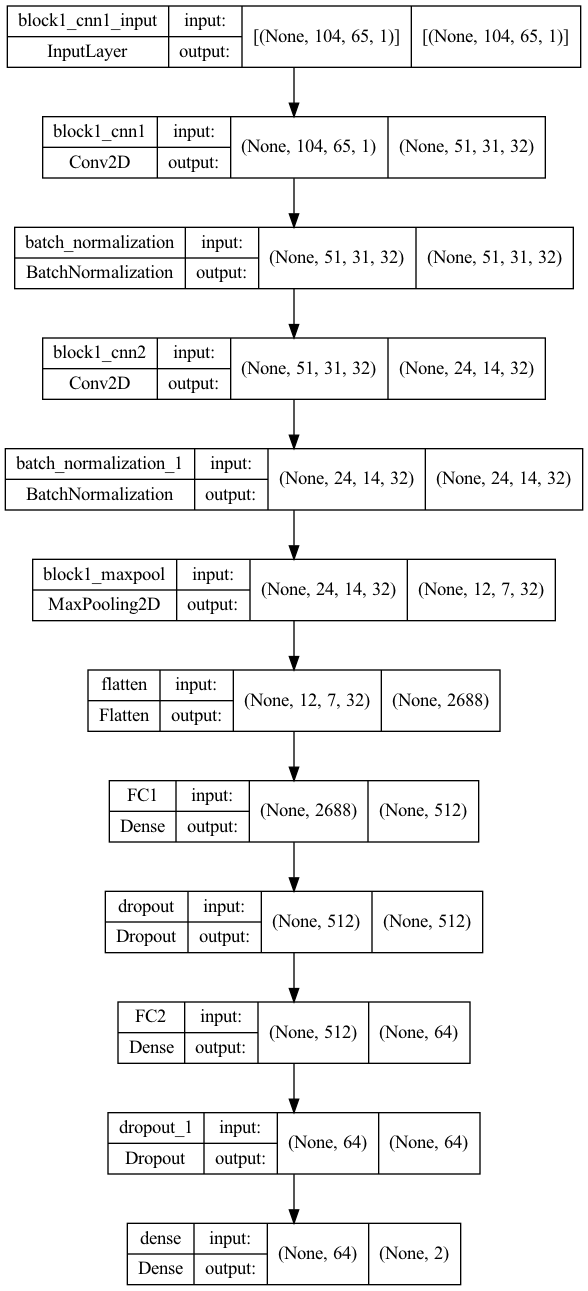

In [22]:
tf.keras.utils.plot_model(CNNmodel, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [23]:
ep=100
history = CNNmodel.fit(x=np.array(X_train, np.float32), 
                       y=np.array(y_train, np.float32), 
                       validation_data = ( np.array(X_validation, np.float32),
                                           np.array(y_validation, np.float32),
                                           ),
                       epochs=ep
                      )

Epoch 1/100


/Users/I550349/workspace/venv3.8/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


4/4 [==============================] - 1s 87ms/step - loss: 4.2195 - accuracy: 0.5476 - val_loss: 2.2627 - val_accuracy: 0.5625
Epoch 2/100
4/4 [==============================] - 0s 44ms/step - loss: 2.0096 - accuracy: 0.6032 - val_loss: 0.7843 - val_accuracy: 0.4375
Epoch 3/100
4/4 [==============================] - 0s 42ms/step - loss: 1.0498 - accuracy: 0.7302 - val_loss: 0.7089 - val_accuracy: 0.5625
Epoch 4/100
4/4 [==============================] - 0s 47ms/step - loss: 1.1343 - accuracy: 0.6825 - val_loss: 0.3603 - val_accuracy: 0.9062
Epoch 5/100
4/4 [==============================] - 0s 42ms/step - loss: 0.5642 - accuracy: 0.7857 - val_loss: 0.7889 - val_accuracy: 0.4375
Epoch 6/100
4/4 [==============================] - 0s 44ms/step - loss: 0.5420 - accuracy: 0.7619 - val_loss: 0.3431 - val_accuracy: 0.8438
Epoch 7/100
4/4 [==============================] - 0s 43ms/step - loss: 0.3217 - accuracy: 0.8571 - val_loss: 0.2445 - val_accuracy: 0.9375
Epoch 8/100
4/4 [===============

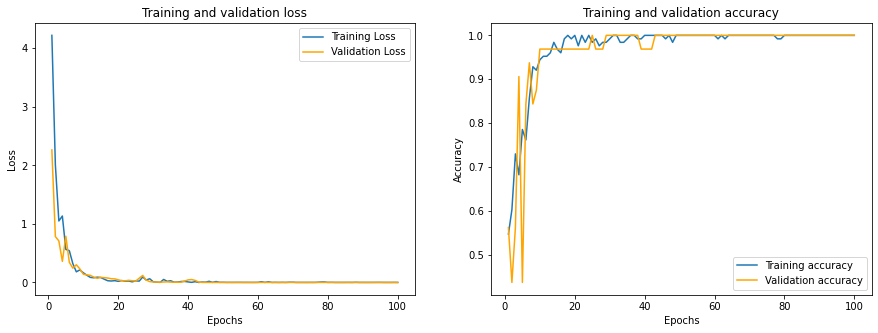

In [24]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,ep+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,label='Training Loss')
ax1.plot(epochs,val_loss_values,'orange', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values, label='Training accuracy')
ax2.plot(epochs,val_acc_values,'orange',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [25]:
score = CNNmodel.evaluate(np.array(X_test, np.float32), np.array(y_test, np.float32))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2/2 [==============================] - 0s 12ms/step - loss: 2.2440e-06 - accuracy: 1.0000
Test loss: 2.244015831820434e-06
Test accuracy: 1.0


In [26]:
type(X_test)

list

In [27]:
type(X_test[0])

numpy.ndarray

In [28]:
pred=CNNmodel(np.array(X_test, np.float32) , training=False)

In [29]:
pred

<tf.Tensor: shape=(40, 2), dtype=float32, numpy=
array([[1.00000000e+00, 3.26994822e-08],
       [1.00000000e+00, 8.70619982e-12],
       [1.56263175e-18, 1.00000000e+00],
       [1.00000000e+00, 5.84432934e-16],
       [1.00000000e+00, 1.57180391e-09],
       [1.00000000e+00, 4.32871072e-10],
       [7.01548315e-16, 1.00000000e+00],
       [4.73901989e-18, 1.00000000e+00],
       [4.39289328e-15, 1.00000000e+00],
       [1.00000000e+00, 5.32544364e-09],
       [9.99999881e-01, 9.20186096e-08],
       [5.05673953e-26, 1.00000000e+00],
       [1.00000000e+00, 9.10145559e-09],
       [1.00000000e+00, 2.01583572e-09],
       [1.00000000e+00, 6.13381013e-11],
       [1.00000000e+00, 2.41466921e-13],
       [9.99999523e-01, 4.78209301e-07],
       [1.00000000e+00, 8.21219803e-09],
       [1.02039536e-17, 1.00000000e+00],
       [1.10038560e-16, 1.00000000e+00],
       [8.00915457e-23, 1.00000000e+00],
       [7.76833906e-15, 1.00000000e+00],
       [6.97350221e-19, 1.00000000e+00],
       [

In [30]:
score = [ np.where(arr == np.amax(arr))[0][0] for arr in np.array(pred) ]

In [31]:
score

[0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0]

### Print Requirements

In [38]:
f = open("../../aicore-test/code/train/requirements.txt",'w')

In [39]:
f.write('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

60

In [40]:
f.close()